In [12]:
%run "00-common"

import sklearn as sk
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

import sklearn.model_selection as cv
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, VotingClassifier
import sklearn.ensemble as en
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

df = pd.read_csv('../feature_selection.csv')
df.head()

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_duration_err1,koi_duration_err2,koi_depth,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,dec,koi_disposition
0,101.110701,0.000953,-0.000953,0.008060,-0.008060,0.0460,0.2100,-0.2100,878.1,1.61,0.10,-0.08,229.0,0.65,0.14,-0.11,24.1,4133.0,74.0,-82.0,0.023,-0.033,0.561,0.033,41.452209,1
1,4.800654,0.000004,-0.000004,0.000745,-0.000745,0.7850,0.0550,-0.0550,15304.0,16.91,6.01,-2.00,1347.0,778.45,793.72,-255.78,298.0,6715.0,161.0,-241.0,0.056,-0.224,1.241,0.441,38.999008,0
2,39.593105,0.000615,-0.000615,0.014000,-0.014000,0.0044,0.5980,-0.5980,156.6,1.22,0.51,-0.11,546.0,21.06,26.65,-6.05,5.7,6046.0,172.0,-218.0,0.044,-0.298,0.972,0.411,41.659611,0
3,31.158825,0.000057,-0.000057,0.001380,-0.001380,0.0290,0.0504,-0.0504,959.0,3.56,0.57,-0.46,639.0,39.46,17.49,-11.96,73.6,5951.0,107.0,-119.0,0.120,-0.120,1.155,0.184,38.710232,1
4,613.829050,0.032600,-0.032600,0.031900,-0.031900,0.2616,1.4000,-1.4000,148.2,2.85,1.25,-1.41,307.0,2.10,2.78,-1.62,10.2,5636.0,173.0,-148.0,0.459,-0.224,2.357,1.027,43.824032,0


In [3]:
y = df['koi_disposition']
X = df.drop('koi_disposition', axis=1)
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size=.3, stratify=y, random_state=1)

In [20]:
nb = Pipeline(steps=[
    ('Scaler', preprocessing.PowerTransformer() ),
    ('NCA', NeighborhoodComponentsAnalysis(random_state=1)),
    ('NB', GaussianNB())])
knn = Pipeline(steps=[
    ('Scaler', preprocessing.StandardScaler()),
    ('KNN', KNeighborsClassifier(n_neighbors=7, weights='distance')),
     ])
dt = DecisionTreeClassifier(criterion='entropy')

svm = Pipeline(steps=[
    ('Scaler', preprocessing.MinMaxScaler(feature_range=(-1, 1))),
    ('SVM', SVC(kernel='linear', C=1e5)),
])

voting = VotingClassifier(estimators=[('nb', nb), ('knn', knn), ('dt', dt)], voting='hard')

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200, max_features=0.9)

rf_params = {'bootstrap': False,
 'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}
rf = en.RandomForestClassifier(**rf_params)

abc = en.AdaBoostClassifier(learning_rate=0.5, n_estimators=60)

classifiers = {
    'nb': nb,
    'knn': knn,
    'dt': dt,
    'svm': svm,
    'voting': voting,
    'bag': bag,
    'rf': rf,
    'ada': abc,
}

In [21]:
for (method, cf) in classifiers.items():
    print('Fitting', method)
    cf.fit(X_train, y_train)

Running nb
Running knn
Running dt
Running svm
Running voting
Running bag
Running rf
Running ada


In [16]:
import pickle

with open('pickles/all-trained.pkl', 'wb') as out:
    pickle.dump(methods, out)

In [44]:
dd = y_test.to_frame()

for (method, cf) in classifiers.items():
    print('Running', method)
    pred = cf.predict(X_test)
    dd[method] = pred

Running nb
Running knn
Running dt
Running svm
Running voting
Running bag
Running rf
Running ada


In [25]:
y_test

940     0
1633    1
1632    0
187     1
941     0
       ..
1739    1
1223    0
1459    0
285     0
792     0
Name: koi_disposition, Length: 600, dtype: int64

In [45]:
dd

,koi_disposition,nb,knn,dt,svm,voting,bag,rf,ada
940,0,0,0,0,0,0,0,0,0
1633,1,1,1,1,1,1,1,1,1
1632,0,0,1,0,0,0,0,0,0
187,1,1,1,0,1,1,1,1,1
941,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1739,1,1,1,1,1,1,1,1,1
1223,0,0,0,0,0,0,0,0,0
1459,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0


In [46]:
ddd = pd.DataFrame()
for c in dd.columns[1:]:
    ddd[c] = dd[c] == dd.koi_disposition

In [107]:
from statsmodels.stats.contingency_tables import mcnemar

pvalues = np.ones(shape=(n,n))
statistics = np.zeros(shape=(n,n))

n = len(ddd.columns)
for i in range(n):
    for j in range(i+1, n):
        tab = pd.crosstab(ddd.iloc[:,i], ddd.iloc[:,j])
        res = mcnemar(tab)
        pvalues[i][j] = res.pvalue
        pvalues[j][i] = res.pvalue
        statistics[i][j] = res.statistic
        statistics[j][i] = res.statistic
        
        tab.to_latex('../tables/crosstab_{}_{}.tex'.format(i, j))

In [67]:
pvalues

array([[1.00000000e+00, 4.21523344e-01, 5.85646795e-01, 4.27240503e-03,
        1.64149134e-03, 2.87118450e-04, 3.76061213e-05, 8.83755633e-05],
       [4.21523344e-01, 1.00000000e+00, 1.37367971e-01, 1.76309230e-04,
        2.24755940e-05, 7.24415651e-06, 9.67489114e-07, 3.39716682e-06],
       [5.85646795e-01, 1.37367971e-01, 1.00000000e+00, 4.13914287e-02,
        2.26288412e-02, 1.19512032e-03, 4.19341579e-05, 6.21043456e-04],
       [4.27240503e-03, 1.76309230e-04, 4.13914287e-02, 1.00000000e+00,
        8.91923151e-01, 4.88455669e-01, 2.22052820e-01, 3.36783635e-01],
       [1.64149134e-03, 2.24755940e-05, 2.26288412e-02, 8.91923151e-01,
        1.00000000e+00, 2.79956239e-01, 9.88717496e-02, 2.11023598e-01],
       [2.87118450e-04, 7.24415651e-06, 1.19512032e-03, 4.88455669e-01,
        2.79956239e-01, 1.00000000e+00, 6.63623810e-01, 1.00000000e+00],
       [3.76061213e-05, 9.67489114e-07, 4.19341579e-05, 2.22052820e-01,
        9.88717496e-02, 6.63623810e-01, 1.00000000e+00, 8.

In [66]:
statistics

array([[ 0., 45., 39., 21., 12., 18., 15., 15.],
       [45.,  0., 37., 21., 11., 18., 16., 17.],
       [39., 37.,  0., 26., 14., 14.,  8., 13.],
       [21., 21., 26.,  0., 26., 23., 17., 16.],
       [12., 11., 14., 26.,  0., 17., 13., 16.],
       [18., 18., 14., 23., 17.,  0.,  9., 17.],
       [15., 16.,  8., 17., 13.,  9.,  0., 14.],
       [15., 17., 13., 16., 16., 17., 14.,  0.]])

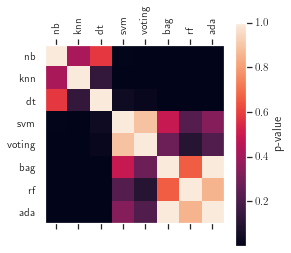

In [97]:
plt.matshow(pvalues)
plt.colorbar(label='p-value')
plt.grid(b=None)
plt.xticks(np.arange(n), ddd.columns, rotation=90)
plt.yticks(np.arange(n), ddd.columns, rotation=0)
plt.savefig('../figures/mcnemar_pvalue.pdf')

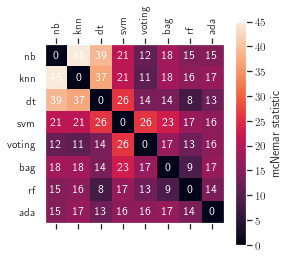

In [96]:
#fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
plt.matshow(statistics)

plt.colorbar(label='mcNemar statistic')
plt.grid(b=None)
plt.xticks(np.arange(n), ddd.columns, rotation=90)
plt.yticks(np.arange(n), ddd.columns, rotation=0)

for (i, j), z in np.ndenumerate(statistics):
    plt.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', color = 'white', weight='bold')
            #bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.savefig('../figures/mcnemar.pdf')

In [98]:
pvalues

array([[1.00000000e+00, 4.21523344e-01, 5.85646795e-01, 4.27240503e-03,
        1.64149134e-03, 2.87118450e-04, 3.76061213e-05, 8.83755633e-05],
       [4.21523344e-01, 1.00000000e+00, 1.37367971e-01, 1.76309230e-04,
        2.24755940e-05, 7.24415651e-06, 9.67489114e-07, 3.39716682e-06],
       [5.85646795e-01, 1.37367971e-01, 1.00000000e+00, 4.13914287e-02,
        2.26288412e-02, 1.19512032e-03, 4.19341579e-05, 6.21043456e-04],
       [4.27240503e-03, 1.76309230e-04, 4.13914287e-02, 1.00000000e+00,
        8.91923151e-01, 4.88455669e-01, 2.22052820e-01, 3.36783635e-01],
       [1.64149134e-03, 2.24755940e-05, 2.26288412e-02, 8.91923151e-01,
        1.00000000e+00, 2.79956239e-01, 9.88717496e-02, 2.11023598e-01],
       [2.87118450e-04, 7.24415651e-06, 1.19512032e-03, 4.88455669e-01,
        2.79956239e-01, 1.00000000e+00, 6.63623810e-01, 1.00000000e+00],
       [3.76061213e-05, 9.67489114e-07, 4.19341579e-05, 2.22052820e-01,
        9.88717496e-02, 6.63623810e-01, 1.00000000e+00, 8.

In [106]:
tbl = pd.DataFrame(pvalues, index=ddd.columns)
tbl.columns = ddd.columns
tbl.to_latex('../tables/mcnemar_pvalues.tex', float_format="%.2f")

tbl = pd.DataFrame(statistics, index=ddd.columns)
tbl.columns = ddd.columns
tbl.to_latex('../tables/mcnemar.tex', float_format="%.0f")

In [27]:
import pickle

with open('pickles/train-out.pkl', 'wb') as out:
    pickle.dump(dd, out)